<a href="https://colab.research.google.com/github/ermaury/k_brazos_AM_DE_JP/blob/main/P1/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: Luis Daniel Hernández Molinero
    Email: ldaniel@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [ ]:

# Descargar el repositorio
!git clone https://github.com/ermaury/k_brazos_AM_DE_JP.git

# Añadir el subdirectorio al path de importación
import sys, os

# Cambiar al directorio de trabajo donde está P2
repo_path = '/content/k_brazos_AM_DE_JP/P1'
os.chdir(repo_path)

# Confirmar cambio de directorio y añadir al path
print("Directorio actual:", os.getcwd())
sys.path.append(repo_path)


In [ ]:
import numpy as np
from typing import List

from algorithms import Algorithm, UCB1, UCB2
from arms import ArmNormal, ArmBernouilli, ArmBinomial, ArmBeta, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics


semilla = 43

['/home/user/workspace/Extensiones de Machine Learning/Practica1/k_brazos_AM_DE_JP', '/home/user/miniconda3/envs/cvenv/lib/python310.zip', '/home/user/miniconda3/envs/cvenv/lib/python3.10', '/home/user/miniconda3/envs/cvenv/lib/python3.10/lib-dynload', '', '/home/user/miniconda3/envs/cvenv/lib/python3.10/site-packages', '/content/k_brazos_AM_DE_JP', '/content/k_brazos_AM_DE_JP']


## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [10]:
def run_experiment(bandit, algorithms: List, steps: int, runs: int):
    """
    Ejecuta experimentos con múltiples algoritmos sobre un bandit dado.

    :param bandit: Instancia de la clase Bandit.
    :param algorithms: Lista de instancias de algoritmos a evaluar.
    :param steps: Número de pasos de tiempo a simular.
    :param runs: Número de ejecuciones para promediar los resultados.
    
    :return: rewards, optimal_selections, regret_accumulated, arm_stats - 
             Matrices con recompensas, selecciones óptimas, regret acumulado y estadísticas de brazos.
    """

    np.random.seed(semilla)  # Asegurar reproducibilidad
    
    optimal_arm = bandit.optimal_arm  # Índice del brazo óptimo
    optimal_reward = bandit.expected_rewards[optimal_arm]  # Recompensa esperada del brazo óptimo
    num_arms = len(bandit.arms)  # Número total de brazos

    rewards = np.zeros((len(algorithms), steps))  # Matriz para recompensas promedio
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para selecciones óptimas
    regrets = np.zeros((len(algorithms), steps))  # Matriz para regret acumulado

    # Inicializar estadísticas de cada brazo por algoritmo
    arm_stats = [
        {
            'total_rewards': np.zeros(num_arms),  # Suma de recompensas por brazo
            'selections': np.zeros(num_arms),    # Veces que se seleccionó cada brazo
            'optimal_arm': optimal_arm,          # Guardar cuál es el brazo óptimo
        }
        for _ in range(len(algorithms))
    ]

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)  # Nueva instancia del bandit

        # Reiniciar los algoritmos
        for algo in algorithms:
            algo.reset()

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener recompensa
                algo.update(chosen_arm, reward)  # Actualizar valores estimados

                rewards[idx, step] += reward  # Acumular recompensa

                # Si el brazo elegido es el óptimo, incrementar el contador
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del regret instantáneo
                regret = optimal_reward - reward
                regrets[idx, step] += regret

                # Guardar estadísticas del brazo seleccionado
                arm_stats[idx]['total_rewards'][chosen_arm] += reward
                arm_stats[idx]['selections'][chosen_arm] += 1

    # Promediar los valores sobre el número de ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje
    regrets /= runs  # Promediar regret acumulado

    # Calcular promedio de recompensas por brazo
    for idx in range(len(algorithms)):
        # Evitar divisiones por cero (si un brazo no fue seleccionado)
        mask = arm_stats[idx]['selections'] > 0
        arm_stats[idx]['avg_rewards'] = np.zeros(num_arms)
        arm_stats[idx]['avg_rewards'][mask] = arm_stats[idx]['total_rewards'][mask] / arm_stats[idx]['selections'][mask]
        
    return rewards, optimal_selections, regrets, arm_stats

Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan los dos algoritmos UCB para valores alpha = 0.5, 0.1, y 0.01 en el caso de UCB2 y c = 2, 1, 0.5 en el caso de UCB1.

In [16]:
# Parámetros del experimento
np.random.seed(semilla)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

arms = [ArmNormal, ArmBernouilli, ArmBinomial]

# Creación del bandit
bandits = [Bandit(arms=arm.generate_arms(k)) for arm in arms]

results = dict()

for bandit in bandits:
    print(f"Executing Bandit with arm type {bandit.get_type_arms()}")
    
    optimal_arm = bandit.optimal_arm
    print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")
    
    # Definir los algoritmos a comparar. En este caso son 3 algoritmos UCB1 con diferentes valores de parametro c y 3 algoritmos UCB2 con distintos parametros alpha.
    algorithms = [UCB1(k=k, c=0.01), UCB1(k=k, c=1.0), UCB1(k=k, c=3.0), UCB2(k=k, alpha=0.01), UCB2(k=k, alpha=0.3), UCB2(k=k, alpha=0.5)]
    
    # Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
    rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps=1000, runs=500)

    results[bandit.get_type_arms()] = (rewards, optimal_selections, regret_accumulated, arm_stats)

Executing Bandit with arm type ArmNormal
Optimal arm: 8 with expected reward=8.73
Executing Bandit with arm type ArmBernouilli
Optimal arm: 5 with expected reward=0.8666486408992002
Executing Bandit with arm type ArmBinomial
Optimal arm: 10 with expected reward=11.738449608984073


In [17]:
rewards_normal, optimal_selections_normal, regret_accumulated_normal, arm_stats_normal = results['ArmNormal']
rewards_bernouilli, optimal_selections_bernouilli, regret_accumulated_bernouilli, arm_stats_bernouilli = results['ArmBernouilli']
rewards_binomial, optimal_selections_binomial, regret_accumulated_binomial, arm_stats_binomial = results['ArmBinomial']

## Visualización de los resultados (Brazo Normal)

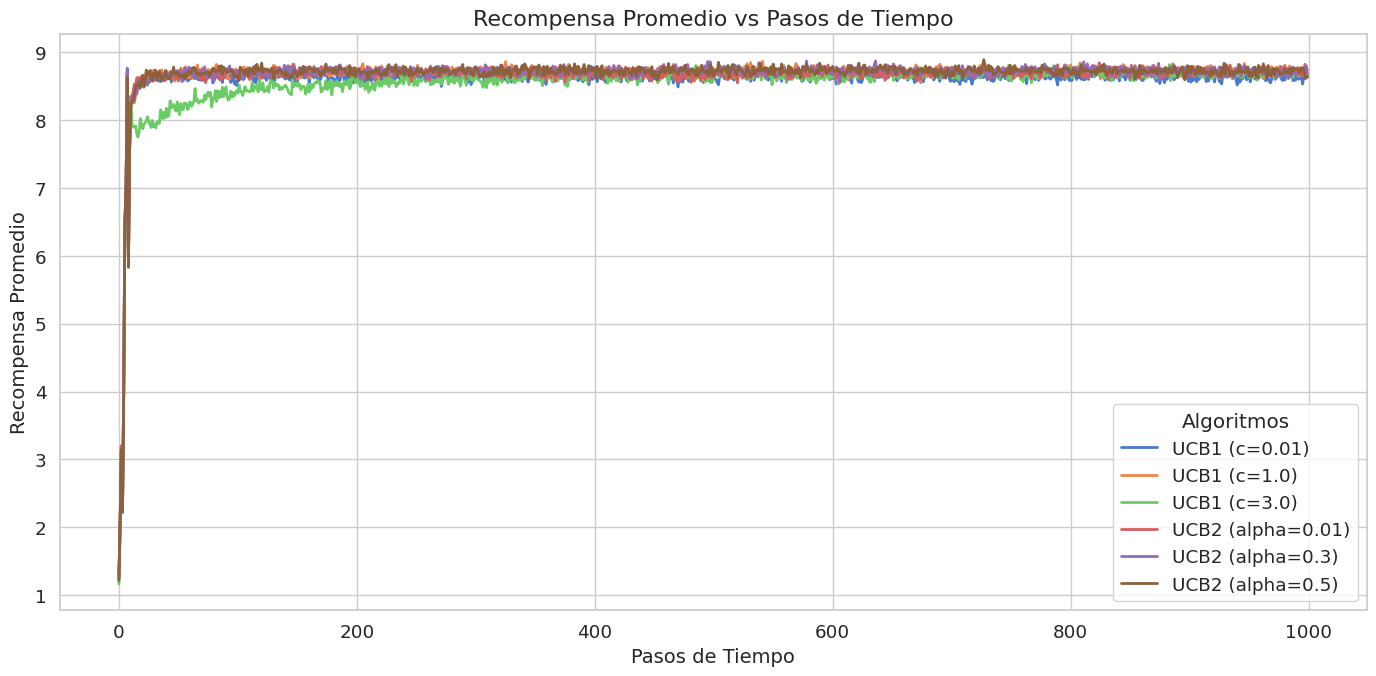

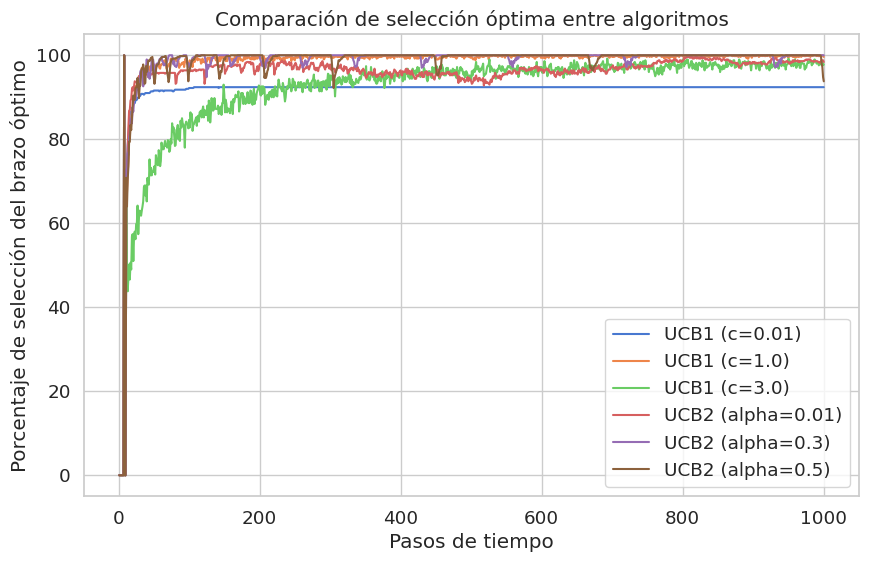

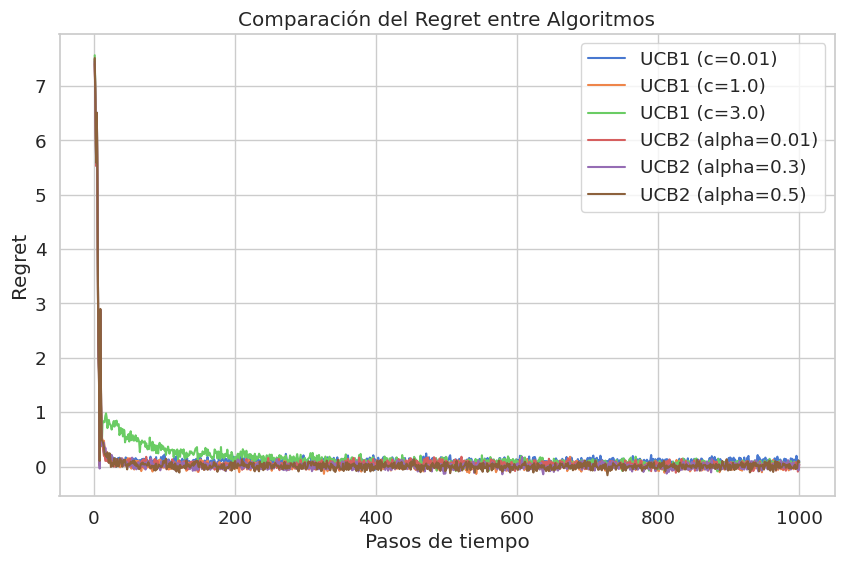

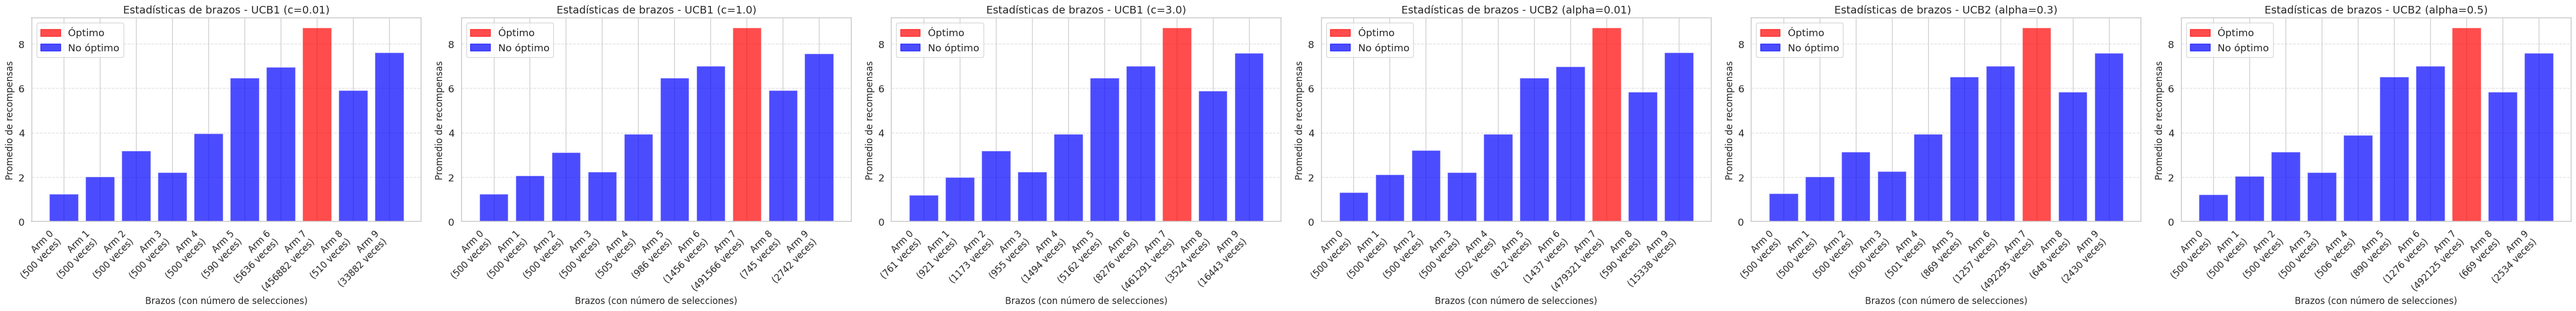

In [18]:
# Graficar los resultados
plot_average_rewards(steps, rewards_normal, algorithms)
plot_optimal_selections(steps, optimal_selections_normal, algorithms)
plot_regret(steps, regret_accumulated_normal, algorithms)
plot_arm_statistics(arm_stats_normal, algorithms)

### Recompensa Promedio vs Pasos de Tiempo

- Todos los algoritmos convergen a una recompensa promedio alta (≈ 8.7–8.9).
- **UCB1 con `c = 3.0`** tiene un inicio más lento (más exploración), pero alcanza buen rendimiento.
- **UCB2 (todos los valores de `alpha`)** presentan una subida rápida y estable.

---

### Porcentaje de Selección del Brazo Óptimo

- **Todos los algoritmos superan el 95%** de selección del óptimo, **excepto UCB1 con `c = 0.01`**, que se queda cerca del **90%**.
- **UCB1 con `c = 3.0`** muestra una convergencia más lenta, pero finalmente se acerca a los mejores valores.
- **UCB1 con `c = 0.01`** muestra una convergencia más temprana, pero su rendimiento final es **ligeramente inferior**, debido a falta de exploración suficiente.
- **UCB2 (`alpha = 0.01`, `0.3`, `0.5`)** converge muy rápidamente y de forma estable hacia la selección del óptimo.

Este gráfico refleja que **una exploración demasiado baja puede ser perjudicial**, como ocurre con `c = 0.01`.

---

### Regret Acumulado vs Pasos de Tiempo

- Todos los algoritmos reducen el regret con el tiempo.
- **UCB1 con `c = 3.0`** acumula más regret al inicio, pero lo reduce progresivamente.
- **UCB2 (todos)** tienen un regret bajo desde los primeros pasos.

---

### Estadísticas de Selección y Recompensa por Brazo

- **UCB1 con `c = 3.0`** y **UCB2 con `alpha = 0.5`** exploran más activamente.
- **UCB1 (`c = 1.0`) y UCB2 (`alpha = 0.3`)** logran un equilibrio excelente entre exploración y explotación.

---

### Conclusión

En entornos con **recompensas normales**, los algoritmos UCB muestran muy buen rendimiento general, pero:

- **Explorar muy poco (c = 0.01)** puede ser contraproducente, ya que impide corregir malas decisiones iniciales.
- **Explorar demasiado (c = 3.0 o `alpha = 0.5`)** puede ralentizar la explotación, pero garantiza convergencia.

## Visualización de los resultados (Distribución Bernoulli)

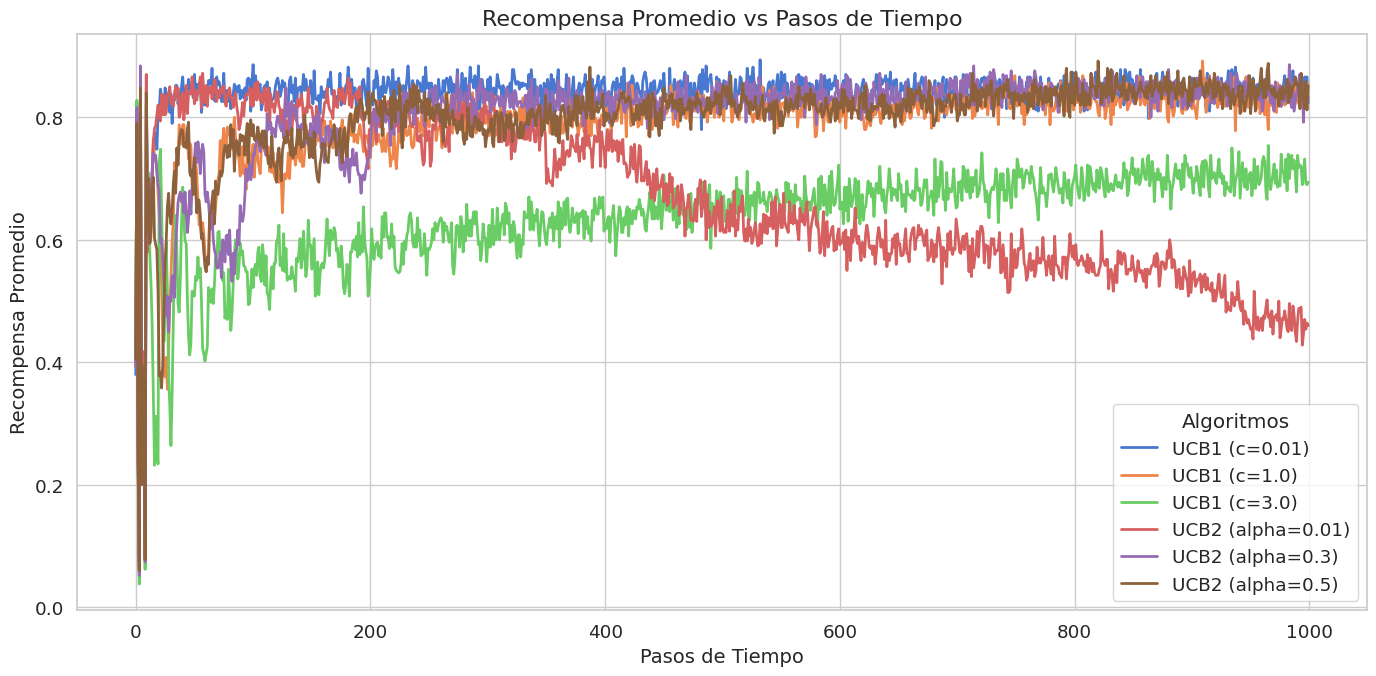

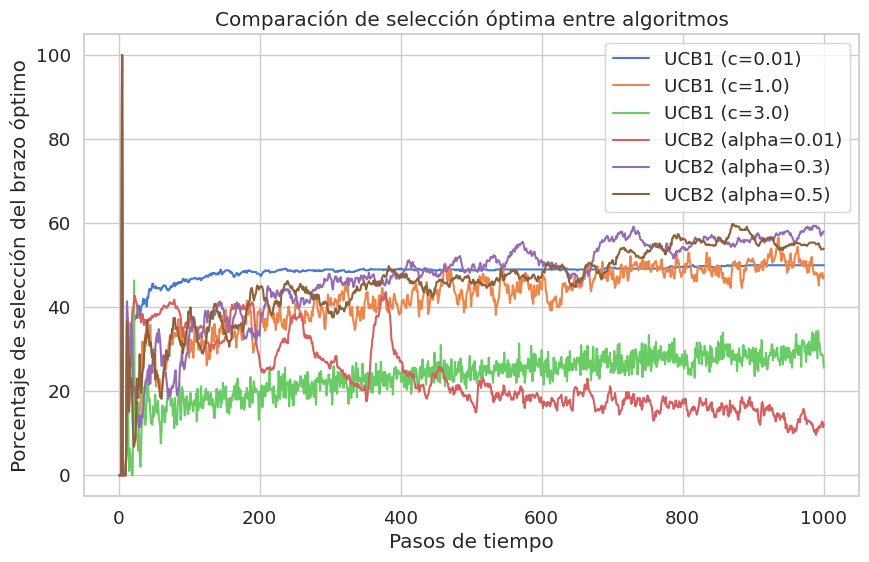

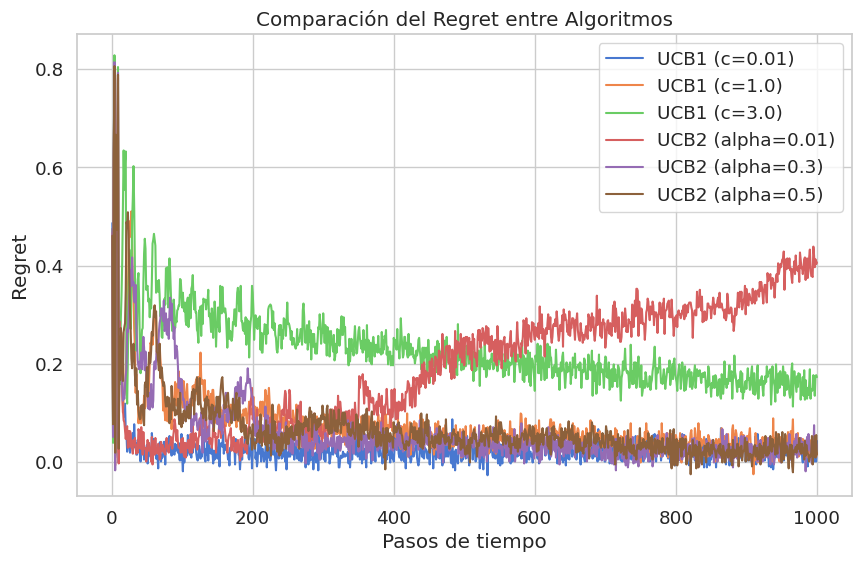

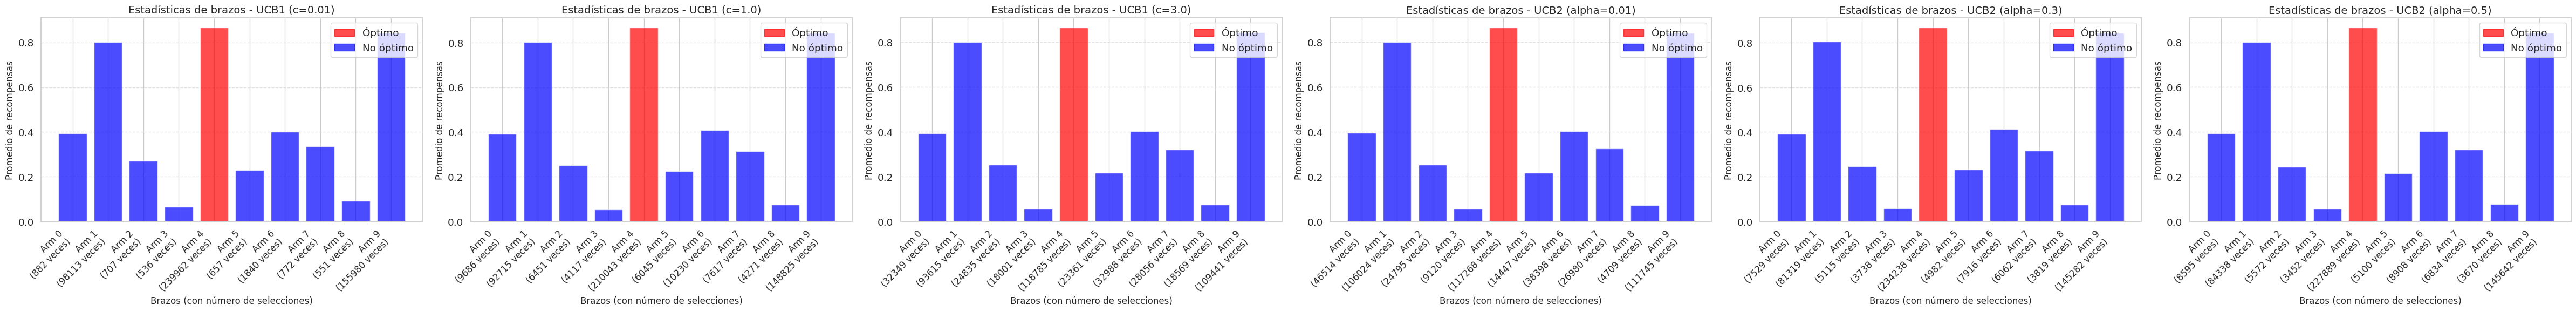

In [19]:
# Graficar los resultados
plot_average_rewards(steps, rewards_bernouilli, algorithms)
plot_optimal_selections(steps, optimal_selections_bernouilli, algorithms)
plot_regret(steps, regret_accumulated_bernouilli, algorithms)
plot_arm_statistics(arm_stats_bernouilli, algorithms)

### Recompensa Promedio vs Pasos de Tiempo

- **UCB1 con `c = 0.01`** alcanza la mayor recompensa promedio (~0.87), lo que indica rápida convergencia al brazo óptimo con poca exploración.
- **UCB1 con `c = 1.0` y `3.0`** muestran menor rendimiento (entre 0.6 y 0.8), indicando que la exploración más intensa les hizo pasar más tiempo en brazos subóptimos.
- **UCB2 con `alpha = 0.01`, `0.3`, `0.5`** logran un rendimiento intermedio, pero **`alpha = 0.01`** sufre una caída notable a partir de los 400 pasos, señal de que converge a un brazo erróneo.

Este gráfico muestra cómo una **exploración excesiva** o **mal dirigida** puede perjudicar en problemas con alta varianza y recompensas discretas como en el caso Bernoulli.

---

### Porcentaje de Selección del Brazo Óptimo

- **UCB1 con `c = 0.01`** y `c = 1.0` se aproximan al **50%** de selección del óptimo.
- **UCB1 con `3.0`** converge peor, alrededor del **30%**.
- **UCB2 con `alpha = 0.01`** comienza bien pero luego cae drásticamente.
- **UCB2 con `alpha = 0.3` y `0.5`** se estabilizan cerca del **50–60%**.


---

### Regret Acumulado vs Pasos de Tiempo

- **UCB1 con `c = 0.01`** mantiene el **regret más bajo y estable**.
- **UCB1 con `c = 3.0`** y **UCB2 con `alpha = 0.01`** muestran **regret creciente**, indicativo de convergencia a un brazo subóptimo.
- **UCB2 con `alpha = 0.3` y `0.5`** logran un **regret bajo pero más oscilante**, con mejor comportamiento que `alpha = 0.01`.

La dificultad para discriminar el óptimo en Bernoulli (especialmente con valores de `p` cercanos) se refleja aquí: más exploración **no siempre mejora el regret** si no es eficaz.

---

### Estadísticas de Selección y Recompensa por Brazo

- **UCB1 con `c = 0.01`** se centra fuertemente en el brazo óptimo, aunque otros brazos también fueron explorados mínimamente.
- **UCB1 con `c = 3.0`** distribuye las elecciones de forma más amplia, penalizando la explotación.
- **UCB2 con `alpha = 0.01`** muestra una elección excesiva de un brazo subóptimo (fallo de convergencia).
- **UCB2 con `alpha = 0.3` y `0.5`** muestran distribución equilibrada pero sin una clara dominancia del óptimo.

---

### Conclusión

En problemas con recompensas **binarias y ruidosas**, como Bernoulli, una **exploración demasiado intensa puede impedir la correcta identificación del óptimo**. UCB1 con una exploración mínima (`c = 0.01`) parece ser la estrategia más efectiva en este entorno.


Para entornos discretos y ruidosos, **menos exploración puede ser mejor** si el brazo óptimo no es difícil de encontrar desde el inicio.


## Visualización de los resultados (Distribución Binomial)

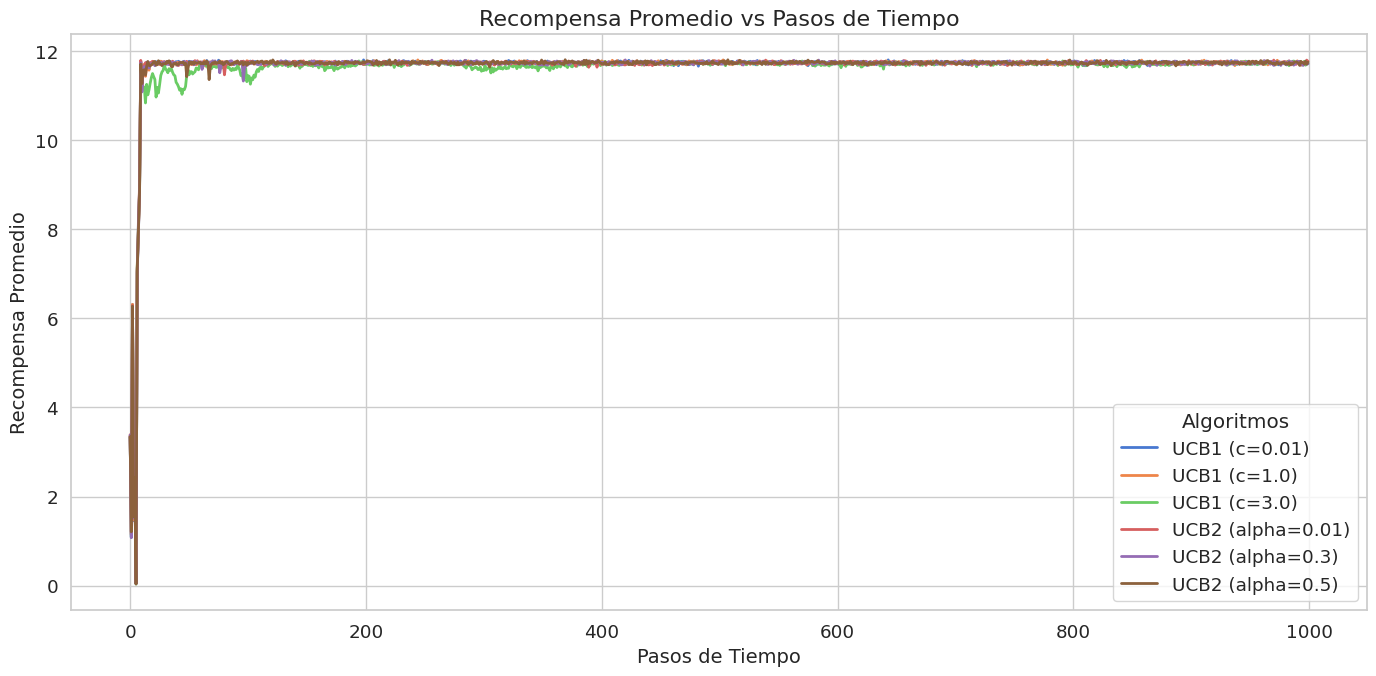

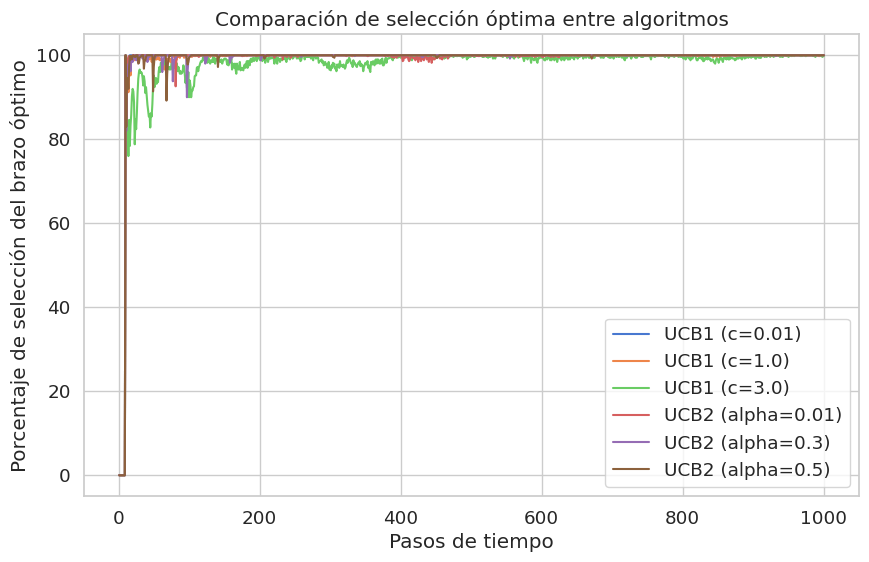

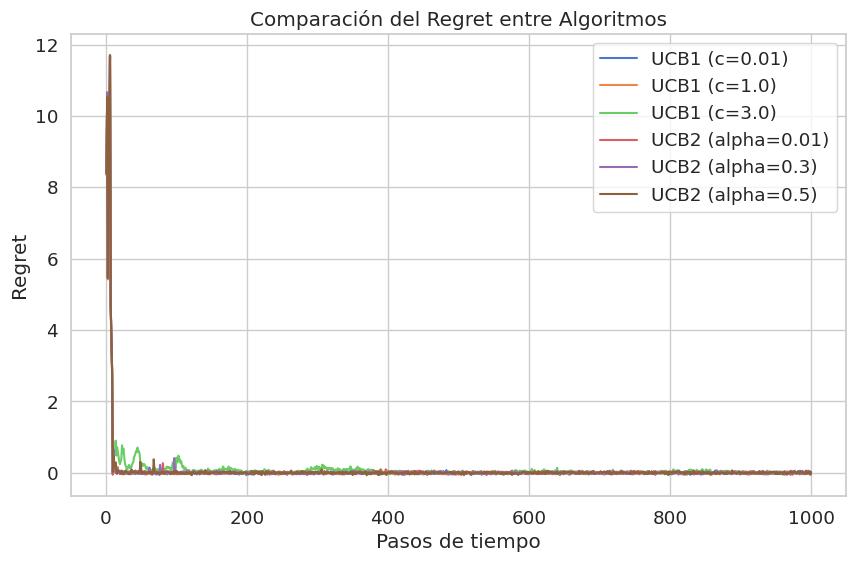

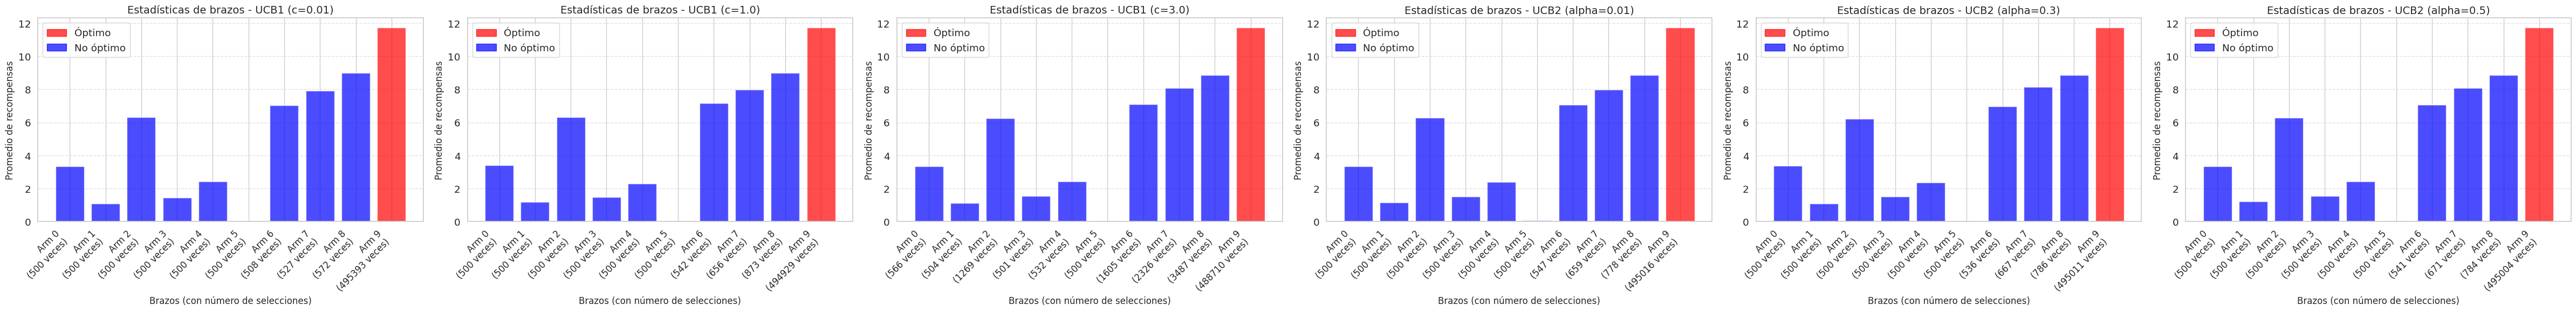

In [20]:
# Graficar los resultados
plot_average_rewards(steps, rewards_binomial, algorithms)
plot_optimal_selections(steps, optimal_selections_binomial, algorithms)
plot_regret(steps, regret_accumulated_binomial, algorithms)
plot_arm_statistics(arm_stats_binomial, algorithms)

### Recompensa Promedio vs Pasos de Tiempo

- Todos los algoritmos convergen muy rápidamente a una recompensa promedio **alta (~12)**.
- No se observan diferencias significativas entre configuraciones de `c` o `alpha` en este aspecto (aunque se aprecian ciertas oscilaciones para el caso de UCB1(`c = 3.0`)).

---

### Porcentaje de Selección del Brazo Óptimo

- Todos los algoritmos alcanzan un **porcentaje de selección del óptimo cercano al 100%**.
- Tanto UCB1 como UCB2 logran identificar el brazo óptimo en muy pocas iteraciones y se mantienen explotándolo de forma estable.

---

### Regret Acumulado vs Pasos de Tiempo

- El **regret inicial** es visible en los primeros pasos, pero cae rápidamente a **casi cero** en todos los algoritmos.
- No hay diferencias significativas entre configuraciones: todas tienen un comportamiento muy eficiente.
- A partir de los 200 pasos, el regret prácticamente desaparece.

Este resultado confirma que el entorno binomial, con mayor información por muestra, permite una identificación más rápida del brazo óptimo.

---

### Estadísticas de Selección y Recompensa por Brazo

- El **brazo óptimo** es claramente el más seleccionado por todos los algoritmos (alrededor de 490.000 selecciones de 500.000).
- Todos los demás brazos fueron seleccionados muy pocas veces (500–1,200), principalmente durante las fases iniciales de exploración.
- Las recompensas promedio reflejan adecuadamente la media esperada de cada brazo, mostrando que los algoritmos realizaron una buena estimación.

---

### Conclusión

En problemas con **recompensas discretas, pero bien diferenciadas y estables** como los binomiales, tanto UCB1 como UCB2 funcionan de forma excelente. Todos los parámetros probados alcanzan rápidamente el óptimo y presentan un **regret muy bajo**.

Este experimento demuestra que, cuando la señal es clara y la varianza es baja, **todas las configuraciones de UCB convergen eficientemente**. No se requieren ajustes finos de los hiperparámetros para lograr un rendimiento óptimo.
